In [82]:
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib

In [9]:
df = pd.read_csv('/Users/zujiewu/Desktop/Zujie’s MacBook Air/ISE350/project/data/cleaned_data.csv')

In [14]:
df = df.iloc[:,1:]

In [15]:
df

,hashtags,tweet
0,covid19,"['covid19', 'era', 'normal', 'influenza', 'sea..."
1,greenpass,"['covid19', 'era', 'normal', 'influenza', 'sea..."
2,greenpass,"['brussel', 'march', 'greenpass', 'novaccinepa..."
3,novaccinepassports,"['brussel', 'march', 'greenpass', 'novaccinepa..."
4,novaccinemandates,"['brussel', 'march', 'greenpass', 'novaccinepa..."
...,...,...
30312,covidiots,"['dr', 'fleme', 'covid', 'caus', 'solut', 'cov..."
30313,vaccinesideeffects,"['dr', 'fleme', 'covid', 'caus', 'solut', 'cov..."
30314,vaccinepassport,"['dr', 'fleme', 'covid', 'caus', 'solut', 'cov..."
30315,vaccinemandate,"['dr', 'fleme', 'covid', 'caus', 'solut', 'cov..."


In [17]:
df = df.reset_index(drop = True)

**Baseline model**

In [20]:
# Baseline Model: random assign
tags = set()
for i in range(len(df)):
     tags.add(df['hashtags'][i])
        
d_test = df.copy()
d_test = d_test.drop(['hashtags'],axis= 1)
d_test['test_tags'] = None

tag_len = len(tags)-1
tags = list(tags)
for j in range(len(df)):
    sel = random.randint(0,tag_len)
    d_test['test_tags'][j] = tags[sel]

y_true = np.array(df['hashtags'])
y_pred = np.array(d_test['test_tags'])

print(classification_report(y_true,y_pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.28      0.02      0.03      8262
vaccinepassport       0.08      0.01      0.02      2802
      greenpass       0.03      0.01      0.02      1052
          covid       0.02      0.01      0.02       775

      micro avg       0.10      0.02      0.03     12891
      macro avg       0.10      0.01      0.02     12891
   weighted avg       0.20      0.02      0.03     12891



**Preoprocess data**

In [23]:
#split X Y (straitified)
def load_data(data):
    x = data['tweet'].tolist()
    y = data['hashtags'].tolist()
    return x, y

X, y = load_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

**TF-IDF Vectorize  
Find the best max_feature(using MultinomialNB)**

In [63]:
def TFIDF_n_features_mnb(n, X_train, y_train, X_test, y_test) -> tuple:
    
    vec = TfidfVectorizer(max_features = n)
    
    # Feature Extraction
    X_tr = vec.fit_transform(X_train)
    X_tst  = vec.transform(X_test)
    # Train Model
    model_mnb = MultinomialNB()
    model_mnb.fit(X_tr, y_train)
    
    # Predict
    pred = model_mnb.predict(X_tst)
   
    return metrics.accuracy_score(y_test,pred)

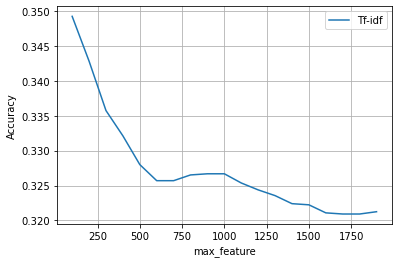

In [46]:
# Select optimal max_features, from 100 to 2000
features_n = [100 * i for i in range(1, 20)]

tfidf_accuracy = []


for i in features_n:
    tfidf_accuracy.append(TFIDF_n_features_mnb(i, X_train, y_train, X_test, y_test))

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

plt.plot(features_n, tfidf_accuracy, label='Tf-idf')
plt.xlabel('max_feature')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Best max_features = 100

**tf-idf vectorize X**

In [48]:
def tfidf_vec(X_train, X_test):
    vec = TfidfVectorizer(max_features = 100)
    X_tr = vec.fit_transform(X_train)
    X_tst  = vec.transform(X_test)
    return X_tr, X_tst

In [49]:
X_train, X_test = tfidf_vec(X_train, X_test)

In [51]:
X_train.shape, X_test.shape

((24253, 100), (6064, 100))

**Modeling wtih tf_idf vec**

In [52]:
# multinomialNB
model_mnb_tf = MultinomialNB()
model_mnb_tf.fit(X_train,y_train)
    
# Predict
pred = model_mnb_tf.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.37      0.96      0.53      1653
vaccinepassport       0.42      0.28      0.33       561
      greenpass       0.50      0.61      0.55       210
          covid       0.57      0.03      0.05       155

      micro avg       0.38      0.73      0.50      2579
      macro avg       0.46      0.47      0.36      2579
   weighted avg       0.40      0.73      0.46      2579



In [74]:
#logistic regression
model_log_tf = LogisticRegression(random_state=0, max_iter = 1000)
model_log_tf.fit(X_train,y_train)

# Predict
pred = model_log_tf.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.53      0.79      0.64      1653
vaccinepassport       0.48      0.61      0.54       561
      greenpass       0.50      0.72      0.59       210
          covid       0.17      0.14      0.15       155

      micro avg       0.51      0.71      0.59      2579
      macro avg       0.42      0.56      0.48      2579
   weighted avg       0.50      0.71      0.58      2579



In [55]:
#svm
model_svc_tf = svm.SVC(kernel='linear')
model_svc_tf.fit(X_train,y_train)

#predict
pred = model_svc_tf.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.52      0.76      0.61      1653
vaccinepassport       0.54      0.51      0.52       561
      greenpass       0.41      0.70      0.51       210
          covid       0.19      0.08      0.12       155

      micro avg       0.50      0.66      0.57      2579
      macro avg       0.41      0.51      0.44      2579
   weighted avg       0.49      0.66      0.56      2579



In [56]:
# Random Forest
rdf_tf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42,max_features = 'sqrt',bootstrap=True,max_depth = 100)
rdf_tf.fit(X_train, y_train)
pred_rf = rdf_tf.predict(X_test)
print(classification_report(y_test, pred_rf, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))


                 precision    recall  f1-score   support

 vaccinemandate       0.47      0.51      0.49      1653
vaccinepassport       0.41      0.40      0.41       561
      greenpass       0.43      0.48      0.45       210
          covid       0.02      0.02      0.02       155

      micro avg       0.43      0.45      0.44      2579
      macro avg       0.33      0.35      0.34      2579
   weighted avg       0.43      0.45      0.44      2579



In [61]:
# xgbboost
xgb_tf = xgb.XGBClassifier(max_depth=6, n_estimators=2, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)
xgb_tf.fit(X_train, y_train)
pred_xgb = xgb_tf.predict(X_test)
print(classification_report(y_test, pred_xgb, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

[00:29:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                 precision    recall  f1-score   support

 vaccinemandate       0.51      0.86      0.64      1653
vaccinepassport       0.45      0.71      0.56       561
      greenpass       0.47      0.75      0.58       210
          covid       0.67      0.01      0.03       155

      micro avg       0.50      0.77      0.60      2579
      macro avg       0.53      0.58      0.45      2579
   weighted avg       0.51      0.77      0.58      2579



**CountVec**

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [64]:
def Count_n_features_mnb(n, X_train, y_train, X_test, y_test) -> tuple:
    
    cou = CountVectorizer(max_features = n)
    
    # Feature Extraction
    X_tr = cou.fit_transform(X_train)
    X_tst  = cou.transform(X_test)
    # Train Model
    model_mnb = MultinomialNB()
    model_mnb.fit(X_tr, y_train)
    
    # Predict
    pred = model_mnb.predict(X_tst)
   
    return metrics.accuracy_score(y_test,pred)

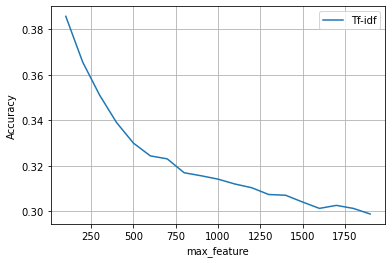

In [68]:
# Select optimal max_features, from 100 to 2000
features_n = [100 * i for i in range(1, 20)]

count_accuracy = []


for i in features_n:
    count_accuracy.append(Count_n_features_mnb(i, X_train, y_train, X_test, y_test))

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

plt.plot(features_n, count_accuracy, label='Tf-idf')
plt.xlabel('max_feature')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Max_feaertu = 100 have best accuracy

**Count vectorize**

In [70]:
def count_vec(X_train, X_test):
    vec = CountVectorizer(max_features = 100)
    X_tr = vec.fit_transform(X_train)
    X_tst  = vec.transform(X_test)
    return X_tr, X_tst

In [71]:
X_train, X_test = tfidf_vec(X_train, X_test)

In [72]:
X_train.shape, X_test.shape

((24253, 100), (6064, 100))

**Modeling wtih countvec**

In [73]:
# multinomialNB
model_mnb_cou = MultinomialNB()
model_mnb_cou.fit(X_train,y_train)
    
# Predict
pred = model_mnb_cou.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.37      0.96      0.53      1653
vaccinepassport       0.42      0.28      0.33       561
      greenpass       0.50      0.61      0.55       210
          covid       0.57      0.03      0.05       155

      micro avg       0.38      0.73      0.50      2579
      macro avg       0.46      0.47      0.36      2579
   weighted avg       0.40      0.73      0.46      2579



In [76]:
#logistic regression
model_log_cou = LogisticRegression(random_state=0, max_iter = 1000)
model_log_cou.fit(X_train,y_train)

# Predict
pred = model_log_cou.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.53      0.79      0.64      1653
vaccinepassport       0.48      0.61      0.54       561
      greenpass       0.50      0.72      0.59       210
          covid       0.17      0.14      0.15       155

      micro avg       0.51      0.71      0.59      2579
      macro avg       0.42      0.56      0.48      2579
   weighted avg       0.50      0.71      0.58      2579



In [77]:
#svm
model_svc_cou = svm.SVC(kernel='linear')
model_svc_cou.fit(X_train,y_train)

#predict
pred = model_svc_cou.predict(X_test)
print(classification_report(y_test, pred, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))

                 precision    recall  f1-score   support

 vaccinemandate       0.52      0.76      0.61      1653
vaccinepassport       0.54      0.51      0.52       561
      greenpass       0.41      0.70      0.51       210
          covid       0.19      0.08      0.12       155

      micro avg       0.50      0.66      0.57      2579
      macro avg       0.41      0.51      0.44      2579
   weighted avg       0.49      0.66      0.56      2579



In [78]:
# Random Forest
rdf_cou = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42,max_features = 'sqrt',bootstrap=True,max_depth = 100)
rdf_cou.fit(X_train, y_train)
pred_rf = rdf_cou.predict(X_test)
print(classification_report(y_test, pred_rf, labels = ['vaccinemandate', 'vaccinepassport','greenpass','covid']))


                 precision    recall  f1-score   support

 vaccinemandate       0.47      0.51      0.49      1653
vaccinepassport       0.41      0.40      0.41       561
      greenpass       0.43      0.48      0.45       210
          covid       0.02      0.02      0.02       155

      micro avg       0.43      0.45      0.44      2579
      macro avg       0.33      0.35      0.34      2579
   weighted avg       0.43      0.45      0.44      2579



In [81]:
# xgbboost
clf_cou = xgb.XGBClassifier(max_depth=6, n_estimators=2, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)
clf_cou.fit(X_train, y_train)
pred_xgb = clf_cou.predict(X_test)
print(classification_report(y_test, pred_xgb, labels = ['vaccinemandate', 'covidpass','vaccinepassport', 'covid19','greenpass']))

[00:39:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                 precision    recall  f1-score   support

 vaccinemandate       0.51      0.86      0.64      1653
      covidpass       0.00      0.00      0.00         0
vaccinepassport       0.45      0.71      0.56       561
        covid19       0.17      0.23      0.20       488
      greenpass       0.47      0.75      0.58       210

      micro avg       0.45      0.72      0.55      2912
      macro avg       0.32      0.51      0.40      2912
   weighted avg       0.44      0.72      0.55      2912



**# xgboost with tf-idf have the best performance overall for its mricro avg, macro avg and weight avg**

In [83]:
#save the best model
filename = 'xgb_tfidf.sav'
joblib.dump(xgb_tf, filename)

['xgb_tfidf.sav']